In [1]:
import sys
# Define relative path.
sys.path.append("python")

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sampling_schemes import morris_trajectory
from screening_measures_gm_2017 import screening_measures_gm_2017

from transform_reorder import reorder_cov
from transform_distributions import covariance_to_correlation
import scipy.linalg as linalg

In [3]:
"""Perhaps I need to add the scaled Elementary Effects (by SD)"""

'Perhaps I need to add the scaled Elementary Effects (by SD)'

In [4]:
def bar_plot(input_par_array):
    new_list = input_par_array.reshape(-1, 1).tolist()
    merged = pd.Series(itertools.chain.from_iterable(new_list))
    vc = merged.value_counts().sort_index()
    vc /= float(vc.sum())
    assert vc.sum() > 0.999
    ax = vc.plot(kind='bar')
    fig = ax.get_figure()
    fig.autofmt_xdate()

In [5]:
"""Example from Ge/Menendez (2017)"""
def linear_function(a, b, c, *args):
    return a + b + c

mu = np.array([0, 0, 0])
"""
cov = np.array(
    [
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ]
)
"""
# Number oflevels rises if there are different covarianzes

cov = np.array(
    [
        [1.0, 0.9, 0.4],
        [0.9, 1.0, 0.0],
        [0.4, 0.0, 1.0],
    ]
)
numeric_zero = 0.01
seed = 2020
n_levels = 10
n_inputs = 3
n_traj_sample = 10_000

traj_list = list()
step_list = list()
for traj in range(0, n_traj_sample):
    seed = seed + traj
    m_traj, step = morris_trajectory(n_inputs, n_levels, seed, True, numeric_zero)
    traj_list.append(m_traj)
    step_list.append(step)

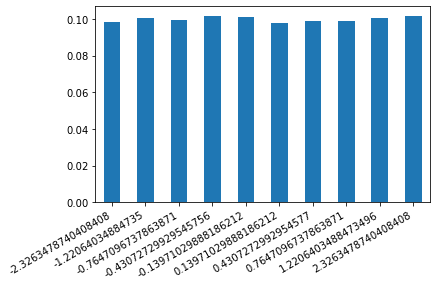

In [6]:
"Check: For some even n_levels 1.0 has double the number of observations."
bar_plot(np.vstack(traj_list))

In [7]:
"""I am able to replicate the results for the two normally distributed examples. The only difference is the scale because they seem to use another number of levels."""
ee_ind, ee_full, abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(linear_function, traj_list, step_list, cov, mu, numeric_zero)

In [8]:
ee_ind

array([[1.],
       [1.],
       [1.]])

In [9]:
abs_ee_ind #last element is largest because it has the lowest correlation.

array([[1.],
       [1.],
       [1.]])

In [10]:
sd_ee_ind

array([[8.23552783e-16],
       [5.54950507e-16],
       [3.13672881e-16]])

In [11]:
ee_full

array([[2.3],
       [1.9],
       [1.4]])

In [12]:
abs_ee_full

array([[2.3],
       [1.9],
       [1.4]])

In [13]:
sd_ee_full

array([[3.10068416e-16],
       [4.21528159e-16],
       [2.41722860e-16]])